# Exploring the Dataset
In this notebook, we will take a first look at the dataset to get a better idea of the data, how it could be analyzed and how it might need to be cleaned up.

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import pycountry
import geopandas

First, we start by loading the data. The [Kaggle dataset description](https://www.kaggle.com/mhwong2007/drug-listing-dataset/) provides the following information about the columns:
* `product_title`: The title of the item.
* `product_description`: The description of the item. This field could be null as some of the listing archives are damaged.
* `ship_from`: The place where the item is shipped from. This field could be null as shipping information isn't required for certain marketplaces.
* `ship_to`: The place where the item is shipped to. This field could be null as shipping information isn't required for certain marketplaces.
* `seller`: The seller of the item.
* `price`: The price of the item, the currency is not yet unified.
* `source`: The name of the marketplace where this item is posted.

In [2]:
df = pd.read_csv("../dat/drug_listings.csv")
df

,product_title,product_description,ship_from,ship_to,seller,price,source
0,10mg Diazepam Tabletten - 10 Stück,- 10mg Diazepam Tabletten - 10 Stück\n\n- Disk...,Germany,Worldwide,1XAnOYMoUsX1BXx,$67.01,1776
1,10mg Diazepam Tabletten - 50 Stück,10 mg Diazepam / Valium / Valocordin Tabletten...,Germany,Worldwide,1XAnOYMoUsX1BXx,$93.82,1776
2,Sonderpreis !!! 10x Diazepam Tropfen 25ml,Diazepam / Valium / Valocordin Tropfen je Flas...,Germany,Worldwide,1XAnOYMoUsX1BXx,$938.32,1776
3,Sonderpreis !!! 2x Diazepam Tropfen 25ml,Diazepam / Valium / Valocordin Tropfen je Flas...,Germany,Worldwide,1XAnOYMoUsX1BXx,$214.46,1776
4,1 gr indian Ketamin,Very Strong Ketamin from India be careful\n\ni...,Austria,Worldwide,ACAB23,$50.00,1776
...,...,...,...,...,...,...,...
194428,∎∎ W. Domino XTC ∎∎ 220MG,White Domino XTC Pills from the Netherlands\n\...,Netherlands,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 42.86\nfor 5 Pills,themarketplace
194429,∎∎ White Domino XTC ► 220mg,White Domino XTC Pills from the Netherlands\n\...,Netherlands,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 42.48\nfor 5 Pills,themarketplace
194430,∎∎ White Domino XTC ► 220mg,White Domino XTC Pills from the Netherlands\n\...,Netherlands,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 42.82\nfor 5 Pills,themarketplace
194431,∎∎ Yellow Grenades ∎∎ 170MG,White Domino XTC Pills from the Netherlands\n\...,Europe,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 30.08\nfor 5 Pills,themarketplace


The following darknet drug marketplaces have been parsed for drug listing data:
* 1776
* Abraxas
* Agora
* Evolution
* Nucleus
* Outlaw Market
* Silk Road 2
* The Marketplace

As a first step, we can check the distribution of drug listings by marketplace. In the figure below, we can see that the [Agora marketplace](https://en.wikipedia.org/wiki/Agora_(online_marketplace)) is responsible for the majority of the listings in the dataset (around 64%, to be precise).

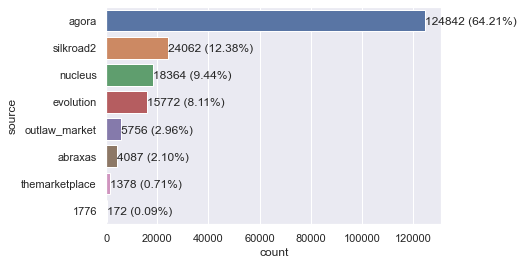

In [3]:
ax = sns.countplot(y='source', data=df, order=df["source"].value_counts().index);
total = df["source"].value_counts().sum()
for p in ax.patches:
    percentage = 100 * p.get_width() / total
    ax.annotate(f'{p.get_width()} ({percentage:.2f}%)', (p.get_width(), p.get_y()+0.55))

Another information present in the dataset is the `ship_from` column (indicating where an item is shipped from). This information could be very interesting for later analysis, since it might allow exploration of questions such as:
* Which countries ship the most drugs?
* (How) do drug prices differ from country to country?
* Are there certain characteristics of a country that correlate with the number of drugs available there? (e.g. GDP, prevalence of mental health issues, ...)

However, when looking at the contents of these country columns (see plot below), we can see they are quite messy: Countries are referred to by different names (e.g. `DE-GERMANY` and `Germany`), by 2-letter and 3-letter country codes (e.g. `GB`, `US`, `USA`) or sometimes grouped as regions (e.g. `European Union` or `Worldwide`).

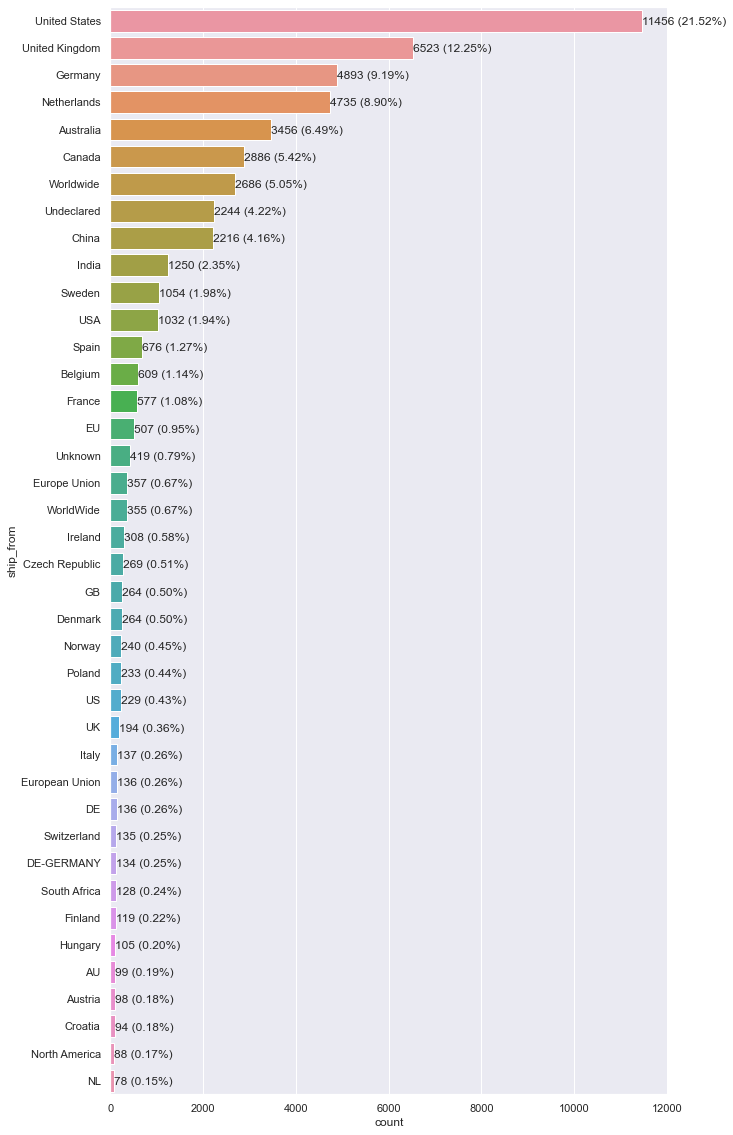

In [4]:
plt.figure(figsize=(10, 20))
ax = sns.countplot(y='ship_from', data=df, order=df["ship_from"].value_counts().head(40).index);
total = df["ship_from"].value_counts().sum()
for p in ax.patches:
    percentage = 100 * p.get_width() / total
    ax.annotate(f'{p.get_width()} ({percentage:.2f}%)', (p.get_width(), p.get_y()+0.55))

To make full use of the information in the `ship_from` column, we need to somehow standardize/group the different representations of country names into a common format. For this, we will use the [pycountry](https://pypi.org/project/pycountry/) library:

In [5]:
def find_country(search_term):
    """ Finds a country in the pycountry library using the given search term. If found, returns its 3-letter alphabetic code, else returns None. 
    
    """
    if pd.isna(search_term):
        # search_term is np.NaN or similar
        return None
    try:
        return pycountry.countries.search_fuzzy(search_term)[0].alpha_3
    except LookupError:
        return None

We will use the function above to try and find a matching country given each `ship_from` entry:

In [108]:
df["ship_from_alpha_3"] = df["ship_from"].apply(lambda country: find_country(country))
df

,product_title,product_description,ship_from,ship_to,seller,price,source,ship_from_alpha_3
0,10mg Diazepam Tabletten - 10 Stück,- 10mg Diazepam Tabletten - 10 Stück\n\n- Disk...,Germany,Worldwide,1XAnOYMoUsX1BXx,$67.01,1776,DEU
1,10mg Diazepam Tabletten - 50 Stück,10 mg Diazepam / Valium / Valocordin Tabletten...,Germany,Worldwide,1XAnOYMoUsX1BXx,$93.82,1776,DEU
2,Sonderpreis !!! 10x Diazepam Tropfen 25ml,Diazepam / Valium / Valocordin Tropfen je Flas...,Germany,Worldwide,1XAnOYMoUsX1BXx,$938.32,1776,DEU
3,Sonderpreis !!! 2x Diazepam Tropfen 25ml,Diazepam / Valium / Valocordin Tropfen je Flas...,Germany,Worldwide,1XAnOYMoUsX1BXx,$214.46,1776,DEU
4,1 gr indian Ketamin,Very Strong Ketamin from India be careful\n\ni...,Austria,Worldwide,ACAB23,$50.00,1776,AUT
...,...,...,...,...,...,...,...,...
194428,∎∎ W. Domino XTC ∎∎ 220MG,White Domino XTC Pills from the Netherlands\n\...,Netherlands,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 42.86\nfor 5 Pills,themarketplace,NLD
194429,∎∎ White Domino XTC ► 220mg,White Domino XTC Pills from the Netherlands\n\...,Netherlands,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 42.48\nfor 5 Pills,themarketplace,NLD
194430,∎∎ White Domino XTC ► 220mg,White Domino XTC Pills from the Netherlands\n\...,Netherlands,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 42.82\nfor 5 Pills,themarketplace,NLD
194431,∎∎ Yellow Grenades ∎∎ 170MG,White Domino XTC Pills from the Netherlands\n\...,Europe,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 30.08\nfor 5 Pills,themarketplace,None


In [6]:
df = pd.read_csv("../dat/drug_listings_cleaned.csv", index_col=0)
df

,product_title,product_description,ship_from,ship_to,seller,price,source,ship_from_alpha_3
0,10mg Diazepam Tabletten - 10 Stück,- 10mg Diazepam Tabletten - 10 Stück\n\n- Disk...,Germany,Worldwide,1XAnOYMoUsX1BXx,$67.01,1776,DEU
1,10mg Diazepam Tabletten - 50 Stück,10 mg Diazepam / Valium / Valocordin Tabletten...,Germany,Worldwide,1XAnOYMoUsX1BXx,$93.82,1776,DEU
2,Sonderpreis !!! 10x Diazepam Tropfen 25ml,Diazepam / Valium / Valocordin Tropfen je Flas...,Germany,Worldwide,1XAnOYMoUsX1BXx,$938.32,1776,DEU
3,Sonderpreis !!! 2x Diazepam Tropfen 25ml,Diazepam / Valium / Valocordin Tropfen je Flas...,Germany,Worldwide,1XAnOYMoUsX1BXx,$214.46,1776,DEU
4,1 gr indian Ketamin,Very Strong Ketamin from India be careful\n\ni...,Austria,Worldwide,ACAB23,$50.00,1776,AUT
...,...,...,...,...,...,...,...,...
194428,∎∎ W. Domino XTC ∎∎ 220MG,White Domino XTC Pills from the Netherlands\n\...,Netherlands,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 42.86\nfor 5 Pills,themarketplace,NLD
194429,∎∎ White Domino XTC ► 220mg,White Domino XTC Pills from the Netherlands\n\...,Netherlands,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 42.48\nfor 5 Pills,themarketplace,NLD
194430,∎∎ White Domino XTC ► 220mg,White Domino XTC Pills from the Netherlands\n\...,Netherlands,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 42.82\nfor 5 Pills,themarketplace,NLD
194431,∎∎ Yellow Grenades ∎∎ 170MG,White Domino XTC Pills from the Netherlands\n\...,Europe,NaN,"∎∎ Sensi ▬ XTC, MDMA & THC",USD 30.08\nfor 5 Pills,themarketplace,NaN


We should note here that upon further inspection, we can see that a lot of the listings have no country information at all (`ship_from` as well as `ship_to`):

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194433 entries, 0 to 194432
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   product_title        194429 non-null  object
 1   product_description  180439 non-null  object
 2   ship_from            53229 non-null   object
 3   ship_to              63623 non-null   object
 4   seller               194303 non-null  object
 5   price                193947 non-null  object
 6   source               194433 non-null  object
 7   ship_from_alpha_3    45873 non-null   object
dtypes: object(8)
memory usage: 13.4+ MB


This means that we are left with a significantly smaller dataset, which also completely changes the distribution of drug marketplaces in the dataset:

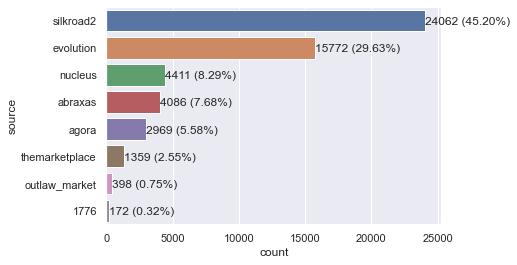

In [8]:
ship_from_info_available = df["ship_from"].notnull()
ax = sns.countplot(y='source', data=df[ship_from_info_available], order=df[ship_from_info_available]["source"].value_counts().index);
total = df[ship_from_info_available]["source"].value_counts().sum()
for p in ax.patches:
    percentage = 100 * p.get_width() / total
    ax.annotate(f'{p.get_width()} ({percentage:.2f}%)', (p.get_width(), p.get_y()+0.55))

In [64]:
#df["ship_to_alpha_3"] = df["ship_to"].apply(lambda country: find_country(country))
#df

AttributeError: 'float' object has no attribute 'strip'